In [1]:
from feos import *
from feos.si import *
from feos.dft import *
from feos.saftvrqmie import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_palette("Paired")
colors = sns.color_palette("Dark2", 3)
sns.set_context("talk")
sns.set_style("ticks")

# Radial distribution function: comparison between Molecular Dynamics and DFT

In this notebook, we compare the radial distribution function (rdf) as obtained from Molecular Dynamics (MD) simulations using LAMMPS and classical DFT.
The steps needed are:

1. Read parameters of the SAFT-VRQ Mie equation of state from files, including binary parameters $k_{ij}$ and $l_ {ij}$.
2. Once the parameters are defined, we can initialize the functional.
3. We calculate the phase diagram of the mixture. We then select thermodynamic conditions for the simulation in the stable liquid phase.
4. Generate the LAMMPS tables for energies and forces for all interaction pairs. Run the simulation (not done here; we provide the simulation output).
5. Read in LAMMPS simulation results. Calculate the rdf using 1D DFT in spherical coordinates.
6. Plot the results.

## Example system: Deuterium-Neon

In this example, we will take a look at the binary system consisting of deuterium and neon.
When you run this example, make sure to adjust the relative path to the parameter files.
Parameters are published in the [FeO$_\mathrm{s}$ github repository](https://github.com/feos-org/feos) in the `parameters` directory.

As part of the SI you will find LAMMPS input files for all binary systems that we presented in the main article.
The procedure to calculate the rdf's is the same as presented in this document.

### Read in parameters

We can read parameter from a *json* file using the `SaftVRQMieParameters.from_json` method.
By default, a list of *names* to define a mixture of substances has to be provided.
We also have to provide a file with the SAFT-VRQ Mie parameters and optionally another file with binary interaction parameters.
If we wanted to use other identifiers instead of the name (CAS, SMILES, ...), we could change the `IdentifierOption` to the appropriate data type.

In [4]:
parameters = SaftVRQMieParameters.from_json(
    ["deuterium", "neon"], 
    "../../parameters/saftvrqmie/hammer2023.json",
    "../../parameters/saftvrqmie/aasen2020_binary.json",
    search_option=IdentifierOption.Name
)
parameters

|component|molarweight|$\sigma$|$\varepsilon$|$\lambda_r$|$\lambda_a$|fh|
|-|-|-|-|-|-|-|
|deuterium|4.028209954364|3.0087|39.2388|11|7|1|
|neon|20.17969806457545|2.7778|37.501|13|6|1|

In [5]:
parameters.k_ij, parameters.l_ij

(array([[0.  , 0.13],
        [0.13, 0.  ]]),
 array([[0., 0.],
        [0., 0.]]))

### Define the functional

Once the parameters are set, we can define the functional.
This is done by the `HelmholtzEnergyFunctional.saftvrqmie` method.
We will use most of the default options in this example; note however that we can include or ignore the non-additive correction to the hard-sphere reference.
To calculate the phase diagram, we will **include the correction term**. 
Later we will use both cases and compare the effect on the rdf.

In [6]:
functional = HelmholtzEnergyFunctional.saftvrqmie(parameters, inc_nonadd_term=True)

### Phase diagram

First, we generate the phase diagram ($p-x,y$ diagram) from which we then select appropriate thermodynamic conditions for our simulation in the stable liquid phase.
The phase diagram is constructed using the `PhaseDiagram.binary_vle` method.
We can either provide a temperature or a pressure as input (FeO$_\mathrm{s}$ checks the actual unit to decide which diagram to compute), in conjunction with the numper of VLE's to be included.
Here, we use a constant temperature of $T = 32$K.
We can access all thermodynamic states of the VLE using the `liquid` and `vapor` fields.
With that, we can generate a nice plot.

In [7]:
temperature = 32 * KELVIN
dia = PhaseDiagram.binary_vle(functional, temperature, npoints=50)

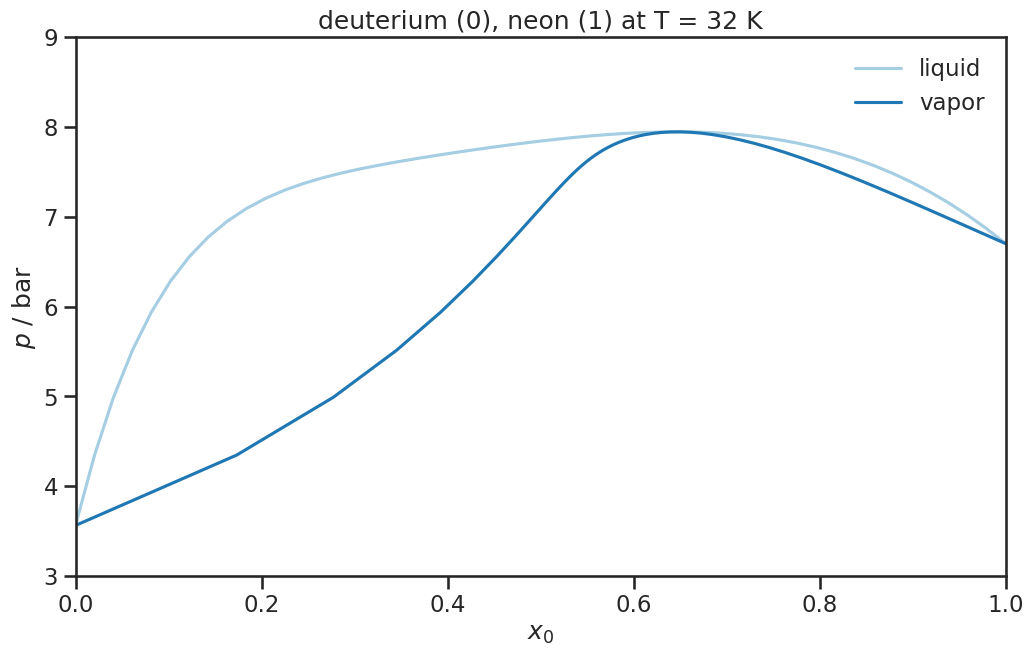

In [8]:
plt.figure(figsize=(12, 7))
plt.title(r"{} (0), {} (1) at T = {}".format(
    parameters.pure_records[0].identifier.name,
    parameters.pure_records[1].identifier.name,
    temperature))

plt.plot(dia.liquid.molefracs[:, 0], dia.liquid.pressure / BAR, label="liquid")
plt.plot(dia.vapor.molefracs[:, 0], dia.vapor.pressure / BAR, label="vapor")
plt.xlim(0, 1.0)
plt.ylim(3, 9)
plt.xlabel(r"$x_0$")
plt.ylabel(r"$p$ / bar")
plt.legend(frameon=False);

We can now specify the thermodynamic condition for our simulation.
Here, we use a pressure of $p = 8$ bar with a molefraction for deuterium of $x_0 = 0.2$.
Note that the order of the indices is the order in which we defined our substances when we read our parameters from files.

In LAMMPS, we conduct a NVT simulation, i.e. at constant temperature ($T = 32$ K), volume and number of molecules.
Thus, given temperature, pressure and the composition, we can calculate the mass density.
We will use the density and composition to later calculate the appropriate volume of our simulation box for a specific number of molecules, here $N=4000$.

The density for given $T, p, \mathbf{x}$ can be calculated using the `State` constructor.
The mass density and the temperature will be inputs for our LAMMPS input file.

In [9]:
pressure = 8 * BAR
x0 = 0.2
molefracs = np.array([x0, 1-x0])

In [10]:
state = State(functional, temperature, pressure=pressure, molefracs=molefracs)
state.mass_density()

812.9908034253755 kg/m³

### Generate LAMMPS energy and force tables

In FeO$_\mathrm{s}$ we provide an utility function to directly export LAMMPS `table` files from the parameters via the `lammps_tables` method of the `SaftVRQMieParameters` object.
This method will create files for all interaction pairs. Here, three files will be generated, one for deuterium-deuterium interactions, one for neon-neon and one for deuterium-neon.

We have to provide the temperature (32 K), the number of points to store in the table (5000), and the minimum and maximum distance (0.1 and 12 Angstrom, respectively).

In [11]:
parameters.lammps_tables(temperature, 5000, 0.1 * ANGSTROM, 12.0 * ANGSTROM)

We provide an input file for the LAMMPS simulation that you can use or adjust for your system.
There are several adjustments necessary, depending on the system of interest.

This is how the LAMMPS input file starts (here it is named `in.binary_deuterium_neon`)

```
units           real
atom_style      atomic

# substance
variable        substance1          string  deuterium
variable        substance2          string  neon
variable        molarweight1        equal   4.028209954364
variable        molarweight2        equal   20.17969806457545

# thermodynamic state
variable        x1                  equal   0.2
variable        initial_density     equal   812.99 # kg / m3 @ p = 8 bar
variable        t                   equal   32
variable        natoms              equal   4000
variable        n1                  equal   v_x1*v_natoms
variable        n2                  equal   v_natoms-v_n1

variable        molarweight_mix     equal   v_x1*v_molarweight1+(1-v_x1)*v_molarweight2
variable        avogadro            equal   6.022*10^23
variable        initial_density_mol equal   v_initial_density/v_molarweight_mix*v_avogadro*10^(-27)  # N / V
variable        unit_cell_volume    equal   1/v_initial_density_mol
variable        box_length          equal   v_unit_cell_volume^(1/3)*v_natoms^(1/3)

variable        rc equal 12.0

```

When changing to other substances, the following changes have to be done

- Adjust the name of the `substance1` and `substance2` variables. The order has to match the order of the parameters for the functional (this will be the filename we generate with `lammps_table`)
- Adjust the molar weights accordingly. Those will be used to calculate the number density from which the volume of the simulation box is calculated.
- Adjust the mole fraction `x1`. Note that in this input we start indexing at `1`.
- Adjust the density (`initial_density`) and temperature variables.
- Adjust the cut-off radius `rc` above which the potential energies and forces are set to zero. That value should match the upper bound that we used to generate our LAMMPS tables.

The substance names are used for the filenames that are generated during the simulation.

You should always **check** the simulation log or output. **A simple consistency check is the density** reported by LAMMPS which has to match the density we computed from the `State` object above.

*Example log output after equilibration:* 
```
Step          Temp          PotEng         KinEng         Volume        Density    
     0   31.487142     -1205.8191      375.3349       138480.42      0.81297093   
  1000   31.608622     -1204.7169      376.78297      138480.42      0.81297093   
  2000   31.951485     -1198.6872      380.86999      138480.42      0.81297093   
  3000   32.182406     -1201.8826      383.62263      138480.42      0.81297093   
  4000   31.835575     -1200.741       379.48831      138480.42      0.81297093   
  5000   31.941999     -1206.9745      380.75691      138480.42      0.81297093   
  6000   31.438711     -1208.0502      374.75759      138480.42      0.81297093   
  7000   31.62501      -1207.2402      376.97832      138480.42      0.81297093
```

### Read simulation results and compute rdf via DFT

Simulation results can be read using `pandas.read_csv`.
To make parsing easier, we can add a `#` in the fourth line and define it as comment when reading the lammps results.

In [12]:
simulation = pd.read_csv(
    'deuterium_neon_32K.rdf', 
    delim_whitespace=True, 
    comment="#",
)
simulation.head()

,i,r,g11,c11,g12,c12,g21,c21,g22,c22
0,1,0.012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For DFT, we construct a second functional without the non-additive correction term (called `functional_additive`).
FeO$_\mathrm{s}$ provides an object to calculate the rdf, the `PairCorrelation`.

`PairCorrelation` takes a `State` as input, which we generate for given  $T, p, \mathbf{x}$ for both functionals.
We can then define the index of the substance that acts as fixed particle, the number of grid points and the maximum radial distance.
Once defined, we call the `solve` method to run the DFT calculation.

After solving the equilibrium density profile, we can access the rdf for each substance given a fixed particle $i$ where $i$ is the index we used to initialize the `PairCorrelation` object.
To get all rdf for a binary system, two DFT calculations have to be conducted: one for substance 0 and one for substance 1 acting as fixed particle.

In [13]:
functional_additive = HelmholtzEnergyFunctional.saftvrqmie(parameters, inc_nonadd_term=False)
state_additive = State(functional_additive, temperature, pressure=pressure, molefracs=molefracs)

state = State(functional, temperature, pressure=pressure, molefracs=molefracs)

rdf0_additive = PairCorrelation(state_additive, 0, 1024, 12 * ANGSTROM).solve()
rdf1_additive = PairCorrelation(state_additive, 1, 1024, 12 * ANGSTROM).solve()

rdf0 = PairCorrelation(state, 0, 1024, 12 * ANGSTROM).solve()
rdf1 = PairCorrelation(state, 1, 1024, 12 * ANGSTROM).solve()

### Plot the results

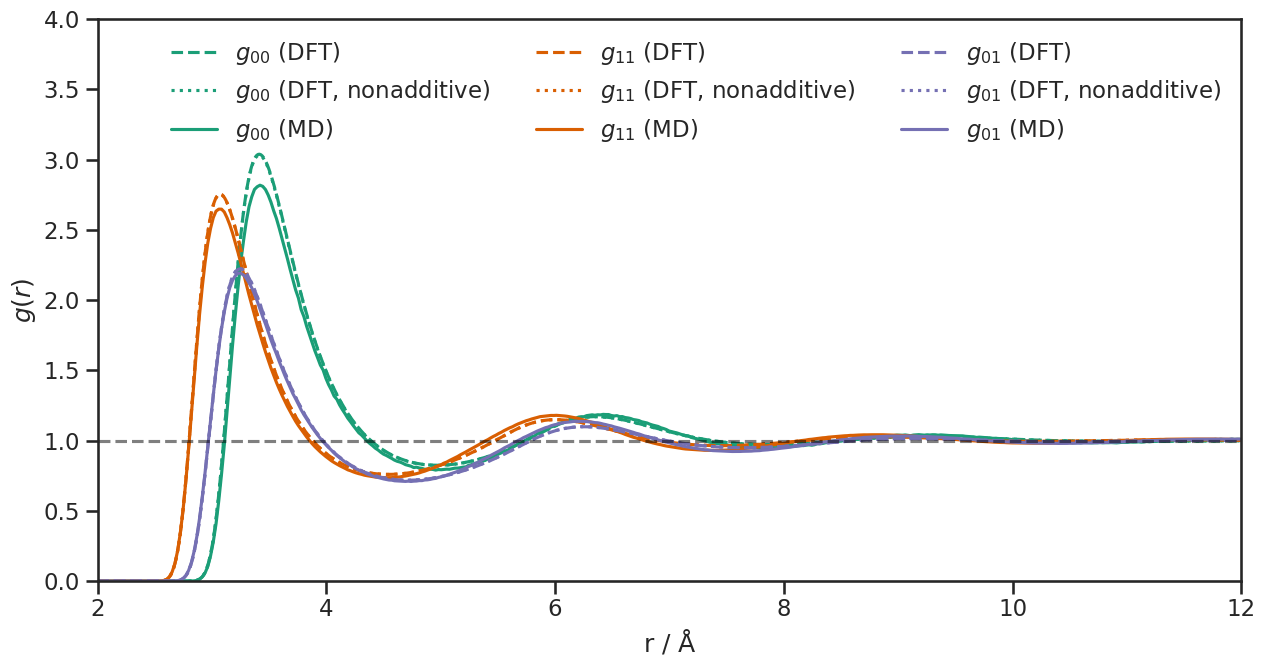

In [14]:
plt.figure(figsize=(13, 7))
plt.plot(rdf0_additive.r / ANGSTROM, rdf0_additive.pair_correlation_function[0], color=colors[0], linestyle='dashed', label=r"$g_{00}$ (DFT)")
plt.plot(rdf0.r / ANGSTROM, rdf0.pair_correlation_function[0], color=colors[0], linestyle='dotted', label=r"$g_{00}$ (DFT, nonadditive)")
plt.plot(simulation.r, simulation.g11, color=colors[0], label=r"$g_{00}$ (MD)")

plt.plot(rdf1_additive.r / ANGSTROM, rdf1_additive.pair_correlation_function[1], color=colors[1], linestyle='dashed', label=r"$g_{11}$ (DFT)")
plt.plot(rdf1.r / ANGSTROM, rdf1.pair_correlation_function[1], color=colors[1], linestyle='dotted', label=r"$g_{11}$ (DFT, nonadditive)")
plt.plot(simulation.r, simulation.g22, color=colors[1], label=r"$g_{11}$ (MD)")

plt.plot(rdf0_additive.r / ANGSTROM, rdf0_additive.pair_correlation_function[1], color=colors[2], linestyle='dashed', label=r"$g_{01}$ (DFT)")
plt.plot(rdf0.r / ANGSTROM, rdf0.pair_correlation_function[1], color=colors[2], linestyle='dotted', label=r"$g_{01}$ (DFT, nonadditive)")
plt.plot(simulation.r, simulation.g12, color=colors[2], label=r"$g_{01}$ (MD)")

plt.hlines(1.0, 0, 15, color="black", linestyle="dashed", alpha=0.5)
plt.xlim(2, 12)
plt.ylim(0, 4.0)

plt.xlabel(r"r / $\mathrm{\AA}$")
plt.ylabel("$g(r)$")

plt.legend(frameon=False, loc="best", ncol=3);
plt.tight_layout()